# Actividad Guiada 1 de Algoritmos de Optimización


Nombre: Carlos Javier Bravo Intriago

https://colab.research.google.com/drive/1O-szoWNwIfQvto4LrLKE7O1djeIBm0kq?usp=sharing

https://github.com/carlosbravo1408/03MIAR-Algoritmos-de-Optimizacion-2025/tree/main/AG1

In [120]:
import copy
import timeit
import tracemalloc
import time
from functools import wraps
from typing import List, Union, Tuple, Callable, Optional

from IPython.display import HTML
from matplotlib.axes import Axes
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np


# -------------------------------- Código Auxiliar -------------------------------- #

HanoiTowerSolutionType = List[Tuple[int, int]]
HanoiTowerCallableType = Callable[[int, int, int, HanoiTowerSolutionType], None]
NQueenSolution = Union[List[int], Tuple[int, ...]]


# Decorador medidor de tiempo
def measure_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        elapsed_time = end_time - start_time
        display(HTML(f"Tiempo de ejecucion: {elapsed_time} seg"))
        return result
    return wrapper

# Decorador medidor de Memoria
def measure_memory(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        tracemalloc.start()
        result = func(*args, **kwargs)
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        # 1 << 10 = 1024, 1 << (10*2) = 1024**2  Conversion a MB
        display(HTML(f"Memoria usada aproximada: {peak/(1<<(10*2))} MB"))
        return result
    return wrapper

# Decorador medidor de tiempo con timeit
# https://stackoverflow.com/a/17579466
def measure_time_accurately(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        t = timeit.Timer(lambda: func(*args, **kwargs))
        times = t.repeat(repeat=3, number=1)
        avg_time = sum(times) / len(times)
        display(HTML(f"Tiempo de ejecucion: {avg_time} seg"))
        return result
    return wrapper

# método auxiliar para probar las variantes de Torre de Hanoi Propuestas
@measure_time_accurately
def get_hanoi_tower_solutions(
        n: int,
        _from: int,
        to: int,
        hanoi_tower_algorithm: HanoiTowerCallableType
) -> HanoiTowerSolutionType:
    solution = []
    hanoi_tower_algorithm(n, _from, to, solution)
    return solution

def draw_board(
        solution: List[int],
        color_board: Tuple[str, str] = ('#FFCE9E', '#D18B47'),
        ax: Optional[Axes] = None,
) -> Axes:
    """
    Método que permite dibujar el tablero de ajedrez a la solución definida en `solution` para el problema de las N-Reinas.
    Este código fue parte de otro proyecto personal y ha sido reescrito para representar las posiciones de las reinas.
    Permite resultados `zero-index` o `one-index`.
    :param solution: Lista con la solución base al modelo [R1, R2, R3, ..., RN] donde cada posición corresponde a su columna, y cada elemento interno corresponde a la fila
    :param color_board: para poder definir el color del tablero, por defecto esta el formato de Lichess.com
    :param ax: Este parametro es opcional, permite agregar este subplot a alguna grafica mas compleja.
    :return: Axes: Retorna el objeto Axes de la figura (Basándose en el Estándar propuesto por Seaborn o Matplotlib)
    """
    n = len(solution)
    starts_with_one = not 0 in solution
    X, Y = np.meshgrid(np.arange(n), np.arange(n))
    board = (X + Y) % 2

    # Seaborn and Matplotlib ecosystem-friendly allows to easily compose complex figures (such as subplots).
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    cmap = ListedColormap(list(color_board))
    ax.imshow(board, cmap=cmap, origin='lower', extent=(0, n, 0, n))

    for col, row in enumerate(solution):
        ax.text(
            col + 0.5 ,
            row + 0.5 - (1 if starts_with_one else 0),
            '♛',
            fontsize=250/n,
            ha='center', va='center',
            color="black"
        )
    # hacky trick for enable horizontal and vertical ticks when ax is defined
    # No reference for this hardcoded part, I only found it through trial and error
    # Carlos Javier Bravo Intriago
    ax.set_xticks(np.arange(0, n, 1))
    ax.set_yticks(np.arange(0, n, 1))
    ax.set_xticks(np.arange(0.5, n, 1), minor=True)
    ax.set_yticks(np.arange(0.5, n, 1), minor=True)

    ax.set_xticklabels([chr(i + 65) for i in range(n)], minor=True)
    ax.set_yticklabels(np.arange(1,n+1), minor=True)
    ax.tick_params(axis='both', which='major', length=0, labelbottom=False, labelleft=False)
    ax.set_title(f"N={n}: Solution {solution}", fontsize=10)
    ax.grid(False)
    return ax

# Torres de Hanoi - Divide y vencerás

<div style="flex: 0 0 300px; text-align: center;">
    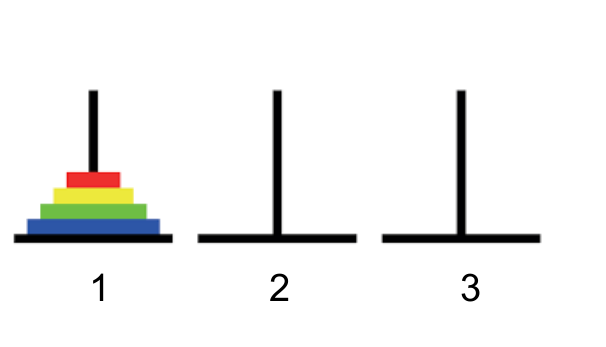
    <p style="text-align: center; font-size: 0.85em; margin-top: 5px; line-height: 1.2;">Fig 1. Torres de Hanoi. <i>Adaptado de <a href="img1">[1]</a></i></p>
</div>

<div style="flex: 0 0 300px; text-align: center;">
    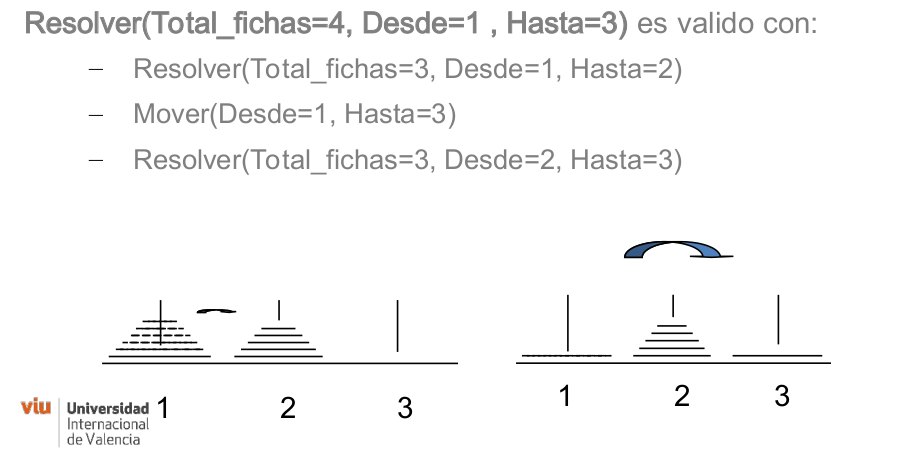
    <p style="text-align: center; font-size: 0.85em; margin-top: 5px; line-height: 1.2;">Fig 2. Esquema de resolucion bajo la estrategia de Divide y vencerás</p>
</div>



> Las llamadas al método print suelen ser lentas en ejecución, si se desea dar un seguimiento al comportamiento del algoritmo se propone imprimir el resultado final, asi para no afectar al tiempo de ejecución en bruto del algoritmo a analizar.
https://www.reddit.com/r/learnpython/comments/7lzbpu/comment/drq7nba/

In [121]:
def hanoi_towers_recursive(n: int, desde: int, hasta: int, sol: HanoiTowerSolutionType) -> None:
    """
    - Autor: Desconocido [Propuesto por el docente]
    - Modificado por: Carlos Javier Bravo Intriago
    - Fecha: Enero 2026
    -----------------------

    Este método contempla la misma logica propuesta por el profesor, con la
    variante de que no imprime por pantalla el resultado, sino que lo retorna
    como una lista de tuplas, cada tupla es un par ordenado que representa
    de que torre a que torre se ha movido la ficha superior.

    Cambios:
    -----------------------
    * Se omite el uso del método `print`
    * Se almacena el resultado en una lista
    * Se usa el operador XOR para buscar la torre o pin auxiliar https://florian.github.io//xor-trick/#application-2-finding-the-missing-number

    :param n: Número de fichas
    :param desde: Torre o pin de Inicio
    :param hasta: Torre o pin final
    :param sol: Referencia de la lista solución, donde se almacenara las tuplas.
    :return: None
    """
    if n==1 :
        sol.append((desde, hasta))
    else:
        pin_auxiliar = desde ^ hasta # Propiedad del operador XOR
        hanoi_towers_recursive(n - 1, desde, pin_auxiliar, sol)
        sol.append((desde, hasta))
        hanoi_towers_recursive(n - 1, pin_auxiliar, hasta, sol)

recursive_solution = get_hanoi_tower_solutions(10, 1, 3, hanoi_towers_recursive)

<div style="flex: 0 0 100px; text-align: center;">
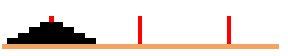
    <p style="text-align: center; font-size: 0.85em; margin-top: 5px; line-height: 1.2;">Fig 3. Torres de Hanoi Iterativo. <i>Recuperado de <a href="img2">[2]</a></i></p>
</div>

Se puede resolver el problema de la Torre de Hanoi de manera no recursiva. Teóricamente hablando, el número minimo de movimientos es $2^n-1$, por lo que podría sugerirse que este problema se puede resolver con $2^n-1$ iteraciones.

### Patron encontrado al analizarse los movimientos
TODO: Agregar explicación Iterativa

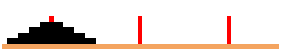

In [122]:
def hanoi_towers_non_recursive(n: int, _from: int, to: int, sol: HanoiTowerSolutionType) -> None:
    """
    - Autor: Vedanti Kshirsagar
    - Corregido y Modificado por: Carlos Javier Bravo Intriago
    - Fuente Original : https://favtutor.com/blogs/tower-of-hanoi
    - Fecha: Enero 2026
    -----------------------

    Variante del algoritmo de las torres de Hanoi no recursiva, basada en la
    propuesta de Vedanti Kshirsagar, y aplicada las correcciones pertinentes.

    -----------------------

    Cambios / Correcciones:
    -----------------------

    * [1] En el orden de los argumentos de cada if-statement
    * [2] En el resultado final, cuando n es par, se deben intercambiar las torres auxiliar por la del destino
    * [3] Cada iteración puede mover hasta 3 discos (no afecta al rendimiento final teóricamente hablando)

    :param n: Número de fichas
    :param _from: Torre o pin de Inicio
    :param to: Torre o pin final
    :param sol: Referencia de la lista solución, donde se almacenara las tuplas.
    :return: None
    """
    _aux = _from ^ to
    if n % 2 == 0:  # Corrección [2]
        _aux, to = to, _aux  # se podría hacer un swap con el truco XOR
    source = [i + 1 for i in reversed(range(n))]
    target = []
    auxiliary = []

    while True:
        if len(target) == n or len(auxiliary) == n:
            break
        if len(source) != 0 and (len(target) == 0 or source[-1] < target[-1]):  # Corrección [1]
            target.append(source.pop())
            sol.append((_from, to))
        else:
            source.append(target.pop())
            sol.append((to, _from))
        if len(target) == n or len(auxiliary) == n:
            break
        if len(auxiliary) != 0 and (len(source) == 0 or auxiliary[-1] < source[-1]):  # Corrección [1]
            source.append(auxiliary.pop())
            sol.append((_aux, _from))
        else:
            auxiliary.append(source.pop())
            sol.append((_from, _aux))
        if len(target) == n or len(auxiliary) == n:
            break
        if len(target) != 0 and (len(auxiliary) == 0 or target[-1] < auxiliary[-1]):  # Corrección [1]
            auxiliary.append(target.pop())
            sol.append((to, _aux))
        else:
            target.append(auxiliary.pop())
            sol.append((_aux, to))

non_recursive_solution = get_hanoi_tower_solutions(10, 1, 3, hanoi_towers_non_recursive)

In [123]:
# validación de respuestas
# esto debería arrojar una Excepción AssertError si no coinciden las respuestas
assert recursive_solution == non_recursive_solution

# Cambio de monedas - Técnica voraz

In [124]:
#Cambio de monedas - Técnica voraz
################################################################################
SISTEMA = [50,20,10,5,1]
################################################################
def cambio_monedas(CANTIDAD, SISTEMA):
#....
    SISTEMA.sort(reverse=True)
    SOLUCION = [0]*len(SISTEMA)
    ValorAcumulado = 0

    for i,valor in enumerate(SISTEMA):
        monedas = (CANTIDAD-ValorAcumulado)//valor
        SOLUCION[i] = monedas
        ValorAcumulado = ValorAcumulado + monedas*valor

        if CANTIDAD == ValorAcumulado:
            return SOLUCION

    print("No es posible encontrar solucion")
cambio_monedas(100,SISTEMA)


################################################################

[2, 0, 0, 0, 0]

# N Reinas - Vuelta Atrás(Backtracking)

<div style="flex: 0 0 200px; text-align: center;">
        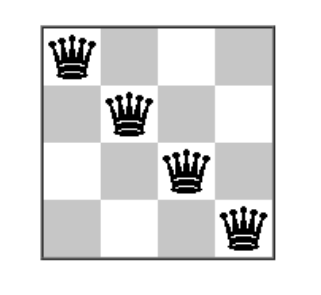
        <p style="text-align: center; font-size: 0.85em; margin-top: 5px; line-height: 1.2;">Fig 3. Problema de las N Reinas.</p>
    </div>
</div>

In [125]:
#N Reinas - Vuelta Atrás()
################################################################################

#Verifica que en la solución parcial no hay amenazas entre reinas
################################################################
def es_prometedora(SOLUCION,etapa):
################################################################

  for i in range(etapa+1):
    if SOLUCION.count(SOLUCION[i]) > 1:
      return False
    for j in range(i+1, etapa +1 ):
      if abs(i-j) == abs(SOLUCION[i]-SOLUCION[j]) : return False
  return True

def reinas(N, soluciones, backtracking=None, etapa=0):
    if backtracking is None:
        backtracking = [0 for _ in range(N)]

    for i in range(1, N+1):
        backtracking[etapa] = i
        if es_prometedora(backtracking, etapa):
            if etapa == N-1:
                soluciones.append(backtracking.copy())
                # print(backtracking)
            else:
                reinas(N, soluciones, backtracking, etapa + 1)
    backtracking[etapa] = 0

@measure_time_accurately
def resolver_reinas(n):
    soluciones = []
    reinas(n, soluciones, etapa=0)
    return soluciones

resolver_reinas(10)

[[1, 3, 6, 8, 10, 5, 9, 2, 4, 7],
 [1, 3, 6, 9, 7, 10, 4, 2, 5, 8],
 [1, 3, 6, 9, 7, 10, 4, 2, 8, 5],
 [1, 3, 9, 7, 10, 4, 2, 5, 8, 6],
 [1, 4, 6, 9, 3, 10, 8, 2, 5, 7],
 [1, 4, 7, 10, 2, 9, 5, 3, 8, 6],
 [1, 4, 7, 10, 3, 9, 2, 5, 8, 6],
 [1, 4, 7, 10, 6, 9, 2, 5, 3, 8],
 [1, 4, 7, 10, 8, 2, 5, 3, 6, 9],
 [1, 4, 7, 10, 8, 3, 5, 9, 2, 6],
 [1, 4, 7, 10, 8, 5, 2, 9, 3, 6],
 [1, 4, 9, 5, 8, 10, 3, 6, 2, 7],
 [1, 4, 9, 7, 2, 10, 3, 6, 8, 5],
 [1, 4, 9, 7, 10, 3, 6, 2, 5, 8],
 [1, 4, 10, 7, 9, 3, 5, 2, 8, 6],
 [1, 5, 7, 2, 10, 8, 4, 9, 3, 6],
 [1, 5, 7, 10, 4, 2, 9, 3, 6, 8],
 [1, 5, 8, 2, 7, 10, 3, 9, 6, 4],
 [1, 5, 8, 10, 3, 7, 2, 4, 6, 9],
 [1, 5, 8, 10, 7, 4, 2, 9, 6, 3],
 [1, 5, 10, 6, 9, 2, 4, 7, 3, 8],
 [1, 6, 4, 7, 10, 3, 9, 2, 5, 8],
 [1, 6, 4, 7, 10, 8, 2, 5, 3, 9],
 [1, 6, 4, 9, 7, 3, 10, 2, 5, 8],
 [1, 6, 4, 10, 7, 9, 3, 5, 2, 8],
 [1, 6, 8, 2, 7, 9, 3, 5, 10, 4],
 [1, 6, 8, 3, 7, 9, 2, 5, 10, 4],
 [1, 6, 8, 5, 2, 9, 3, 10, 7, 4],
 [1, 6, 8, 10, 4, 9, 3, 5, 7, 2],
 [1, 6, 9, 3, 

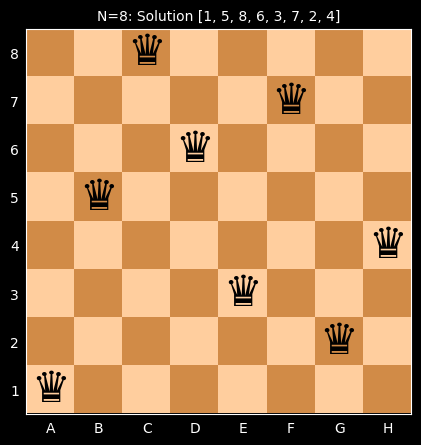

In [126]:
draw_board([1, 5, 8, 6, 3, 7, 2, 4])
plt.show()

## Propuesta del estudiante:

La implementación de este código see tomó como inspiración de la descripción informal de la técnica de backtracking presentada por Knuth D, en [[3](#DK3)], con la variante de que se poda las ramificaciones mientras se amplía la frontera.

El código original hacia dicha poda después de ampliar la frontera. En esta variante propuesta, se poda a la vez que se amplía la frontera.

El método `validate_solution` en la version de Knuth D [[3](#DK3)], implica una complejidad temporal $O(N^2)$, ya que recorre la solución a validar en dos ciclos _for_ anidados. Esta nueva propuesta requiere únicamente un ciclo _for_, esto debido a que se pasa como argumento la `current_queen_row` que se pretende encolar, con ello solo basta ir de la `solution` anterior iterar `row` por `row` para validar si la nueva propuesta de `current_queen_row` ataca a alguna otra reina dentro de `solution`.

#### Análisis temporal:
El coste temporal del método `validate_solution` es $O(N)$.

El coste de hacer backtracking a este problema es teóricamente de $O(N!)$

Por cada iteración dentro del backtracking se llama al método `validate_solution`, lo cual implica que la complejidad temporal es $O(N \times N!)$.


In [127]:
@measure_time_accurately
def solve_n_queens(n: int) -> List[NQueenSolution]:
    if n == 1: return [[0]]  # una unica reina
    if n in [2, 3]: return []  # no existe solucion con 2 o 3 reinas
    solution = [[]]
    for i in range(n):
        solution = extend_with_valid_solutions(solution, n)
    return solution

# Aquí el método validate_solution es de complejidad lineal, se ha quitado la búsqueda redundante por casos ya conocidos
def validate_solution(solution: NQueenSolution, current_queen_row: int) -> bool:
    current_col = len(solution)
    for col, row in enumerate(solution):
        if row == current_queen_row:
            return False
        if abs(current_col - col) == abs(current_queen_row - row):
            return False
    return True

def extend_with_valid_solutions(previous_permutation: list, n: int):
    new_perm = []
    for p in previous_permutation:
        for i in range(n):
            if validate_solution(p, i):
                extended_array = p + [i]
                new_perm.append(extended_array)
    return new_perm

solve_n_queens(10)


[[0, 2, 5, 7, 9, 4, 8, 1, 3, 6],
 [0, 2, 5, 8, 6, 9, 3, 1, 4, 7],
 [0, 2, 5, 8, 6, 9, 3, 1, 7, 4],
 [0, 2, 8, 6, 9, 3, 1, 4, 7, 5],
 [0, 3, 5, 8, 2, 9, 7, 1, 4, 6],
 [0, 3, 6, 9, 1, 8, 4, 2, 7, 5],
 [0, 3, 6, 9, 2, 8, 1, 4, 7, 5],
 [0, 3, 6, 9, 5, 8, 1, 4, 2, 7],
 [0, 3, 6, 9, 7, 1, 4, 2, 5, 8],
 [0, 3, 6, 9, 7, 2, 4, 8, 1, 5],
 [0, 3, 6, 9, 7, 4, 1, 8, 2, 5],
 [0, 3, 8, 4, 7, 9, 2, 5, 1, 6],
 [0, 3, 8, 6, 1, 9, 2, 5, 7, 4],
 [0, 3, 8, 6, 9, 2, 5, 1, 4, 7],
 [0, 3, 9, 6, 8, 2, 4, 1, 7, 5],
 [0, 4, 6, 1, 9, 7, 3, 8, 2, 5],
 [0, 4, 6, 9, 3, 1, 8, 2, 5, 7],
 [0, 4, 7, 1, 6, 9, 2, 8, 5, 3],
 [0, 4, 7, 9, 2, 6, 1, 3, 5, 8],
 [0, 4, 7, 9, 6, 3, 1, 8, 5, 2],
 [0, 4, 9, 5, 8, 1, 3, 6, 2, 7],
 [0, 5, 3, 6, 9, 2, 8, 1, 4, 7],
 [0, 5, 3, 6, 9, 7, 1, 4, 2, 8],
 [0, 5, 3, 8, 6, 2, 9, 1, 4, 7],
 [0, 5, 3, 9, 6, 8, 2, 4, 1, 7],
 [0, 5, 7, 1, 6, 8, 2, 4, 9, 3],
 [0, 5, 7, 2, 6, 8, 1, 4, 9, 3],
 [0, 5, 7, 4, 1, 8, 2, 9, 6, 3],
 [0, 5, 7, 9, 3, 8, 2, 4, 6, 1],
 [0, 5, 8, 2, 7, 3, 1, 9, 4, 6],
 [0, 5, 8,

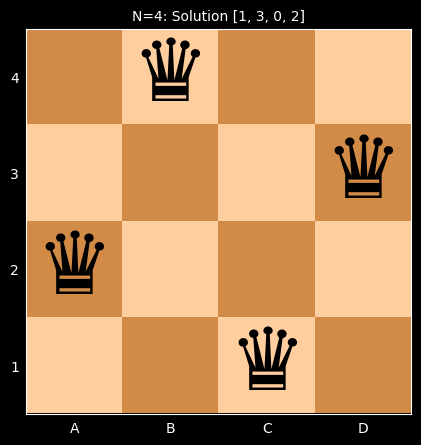

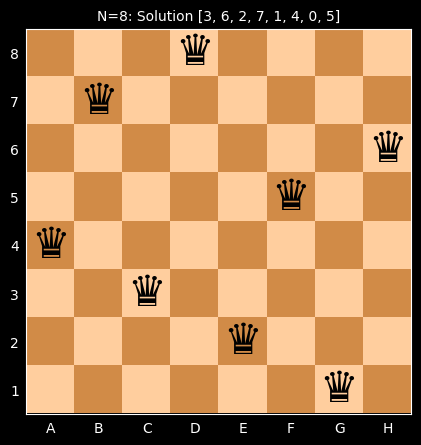

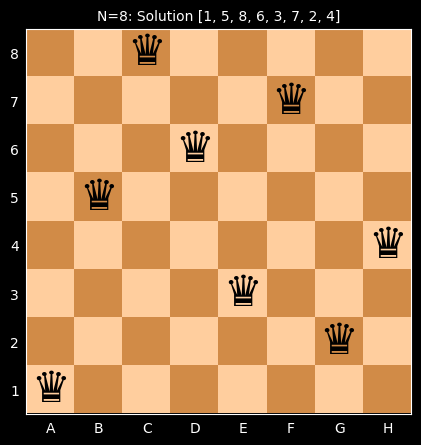

In [128]:
fig, ax = plt.subplots(figsize=(5, 5))
solucion_4 = [1, 3, 0, 2]
draw_board(solucion_4, ax=ax)
plt.show()

solucion_8 = [3, 6, 2, 7, 1, 4, 0, 5]
draw_board(solucion_8)
plt.show()

solucion_origin = [1, 5, 8, 6, 3, 7, 2, 4]
draw_board(solucion_origin)
plt.show()

# Encontrar los dos puntos más cercanos

Dado un conjunto de puntos se trata de encontrar los dos puntos más cercanos entre sí.


In [129]:
import random

PointType = Union[int, Tuple[int, ...]]
PointsListType = List[PointType]
ResultType = Optional[Tuple[PointType, PointType]]

def random_list_generator(start, stop, n, dim):
    if dim == 1:
        return [random.randrange(start, stop) for _ in range(n)]
    return [tuple([random.randrange(start, stop) for _ in range(dim)]) for _ in range(n)]

def get_square_distance(p: PointType, q: PointType) -> int:
    # es computacionalmente innecesario calcular la raiz cuadrada de la
    # hipotenusa, basta con tener la suma de los cuadrados, y comparar con
    # estos
    r = 0
    _ = [r := r + (i - j)**2 for i, j in zip(p, q)] # Operador Walrus, y List Comprehension
    return r

def get_1D_distance(p: PointType, q: PointType) -> int:
    return abs(p - q)

## Caso 1: Puntos en una dimension (1D)

### BruteForce:

Desarrollar un algoritmo por fuerza bruta y obtener la complejidad

In [130]:
def search_nearest_1D_points_bruteforce(points: PointsListType) -> ResultType:
    if 0 <= len(points) <= 1:
        return None
    if len(points) == 2:
        return points[0], points[1]
    lowest_dist = float('inf')
    result_points = None
    for left in range(len(points) - 1):
        for right in range(left + 1 ,len(points)):
            distance = get_1D_distance(points[left], points[right])
            if distance < lowest_dist:
                result_points = ([points[left], points[right]])
                lowest_dist = distance
    return result_points

#### Cálculo de complejidad:

Complejidad Cuadrática $O(M \cdot N)$

### Divide y Vencerás:

Desarrollar un algoritmo con la estrategia Divide y Vencerás, y obtener su complejidad temporal

In [131]:
def search_nearest_1D_points_div_and_conq(points: PointsListType) -> ResultType:
    sorted(points)
    lowest_dist = float('inf')
    result_points = None


## ¿Se puede mejorar?

## Extender el algoritmo a 2D

## Extender el algoritmo a 3D

# Nota sobre el uso de herramientas de IA generativa <a id="ia"></a>

En la elaboración de este notebook se utilizaron herramientas de inteligencia artificial generativa de forma puntual y limitada, exclusivamente como apoyo para la definición de estructuras HTML con fines de presentación.

La redacción del contenido, el desarrollo del código, el diseño del análisis y la interpretación de los resultados son de autoría propia, o se basan en material proporcionado en clase y en recursos disponibles públicamente en línea, los cuales han sido reelaborados y adaptados para los objetivos de este trabajo.

# Referencias Bibliográficas

* [1<a id="img1"></a>] "Anónimo", "Hanoi Towers" Imgur, Octubre 2017. [Imagen en línea]. Disponible en: [https://imgur.com/qslq5kH](https://imgur.com/qslq5kH).
* [2<a id="img2"></a>] Weisstein, Eric W, "Tower of Hanoi" Wolfram Mathworld. [Imagen en línea]. Disponible en: [https://mathworld.wolfram.com/TowerofHanoi.html](https://mathworld.wolfram.com/TowerofHanoi.html).
* [3<a id="DK3"></a>] D. E. Knuth, The Art of Computer Programming, Volume 4A: Combinatorial Algorithms, Part 1. Upper Saddle River, NJ, USA: Addison-Wesley Professional, 2011, sec. 7.2.2, p. 31.